In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import pandas as pd
import torch
import numpy as np
from scipy.stats import pearsonr, spearmanr
import time
from sentence_transformers import SentenceTransformer

# Load the dataset
print("Loading dataset...")
ds = load_dataset("PhilipMay/stsb_multi_mt", "en")
dataset_split = ds['dev']

# Extract data
sentences1 = []
sentences2 = []
ground_truth_scores = []

for sample in dataset_split:
    sentences1.append(sample['sentence1'])
    sentences2.append(sample['sentence2'])
    ground_truth_scores.append(sample['similarity_score'])

print(f"Dataset loaded: {len(sentences1)} sentence pairs")

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model configurations
MODEL_CONFIGS = {
    "all-MiniLM": {
        "type": "sentence_transformer",
        "model_name": "all-MiniLM-L6-v2"
    },
    "all-mpnet": {
        "type": "sentence_transformer",
        "model_name": "all-mpnet-base-v2"
    },
    "gtr-t5-base": {
        "type": "sentence_transformer",
        "model_name": "sentence-transformers/gtr-t5-base"
    },
    "bert-pro": {
        "type": "encoder",
        "model_name": "boltuix/bert-pro"
    },
    "roberta-base": {
        "type": "encoder",
        "model_name": "roberta-base"
    },
    "distilbert": {
        "type": "encoder",
        "model_name": "distilbert-base-uncased"
    },
    "gpt2-small": {
        "type": "decoder",
        "model_name": "gpt2"
    },
    "phi-4-mini": {
        "type": "decoder",
        "model_name": "microsoft/Phi-4-mini-reasoning"
    },
    "qwen2-small": {
        "type": "decoder",
        "model_name": "Qwen/Qwen2-0.5B"
    },
    "tinyllama": {
        "type": "decoder",
        "model_name": "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    },
}


class ModelEvaluator:
    def __init__(self, batch_size=16):
        self.batch_size = batch_size
    
    def get_sentence_transformer_embeddings(self, model_name, sentences1, sentences2):
        print(f"Loading SentenceTransformer: {model_name}")
        model = SentenceTransformer(model_name)
        embeddings1 = model.encode(sentences1, batch_size=self.batch_size)
        embeddings2 = model.encode(sentences2, batch_size=self.batch_size)
        
        return embeddings1, embeddings2
    
    def get_encoder_embeddings(self, model_name, sentences1, sentences2):
        print(f"Loading encoder model: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device)
        model.eval()
        
        def get_embeddings(sentences):
            all_embeddings = []
            for i in range(0, len(sentences), self.batch_size):
                batch_sentences = sentences[i:i + self.batch_size]
                
                # Tokenize sentences
                tokens = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    padding=True,
                    truncation=True,
                    max_length=512
                ).to(device)
                
                # Transformer forward pass
                with torch.no_grad():
                    outputs = model(**tokens)
                    
                    # Mean pooling to get sentence embeddings
                    hidden_states = outputs.last_hidden_state

                    # Expand mask to match hidden states dimensions
                    attention_mask = tokens['attention_mask'].unsqueeze(-1).expand(hidden_states.size()).float()

                    # Zero out padding tokens
                    masked_outputs = hidden_states * attention_mask

                    # Sum all token embeddings (ignore padding)
                    sum_embeddings = torch.sum(masked_outputs, dim=1)

                    # Count real tokens
                    sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)

                    # Calculate mean
                    embeddings = sum_embeddings / sum_mask
                    
                    all_embeddings.extend(embeddings.cpu().numpy())
            
            return np.array(all_embeddings)
        
        embeddings1 = get_embeddings(sentences1)
        embeddings2 = get_embeddings(sentences2)
        
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return embeddings1, embeddings2
    
    def get_decoder_embeddings(self, model_name, sentences1, sentences2):
        print(f"Loading decoder model: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        model.eval()
        
        # Set pad token if not exists
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        def get_embeddings(sentences):
            all_embeddings = []
            for i in range(0, len(sentences), self.batch_size):
                batch_sentences = sentences[i:i + self.batch_size]
                
                # Tokenize sentences
                tokens = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    padding=True,
                    truncation=True,
                    max_length=512
                ).to(device)
                
                with torch.no_grad():
                    outputs = model(**tokens, output_hidden_states=True)
                    hidden_states = outputs.hidden_states[-1]  # Last layer
                    
                    # Mean pooling
                    attention_mask = tokens['attention_mask'].unsqueeze(-1).expand(hidden_states.size()).float()
                    masked_outputs = hidden_states * attention_mask
                    sum_embeddings = torch.sum(masked_outputs, dim=1)
                    sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
                    embeddings = sum_embeddings / sum_mask
                    
                    all_embeddings.extend(embeddings.cpu().numpy())
            
            return np.array(all_embeddings)
        
        embeddings1 = get_embeddings(sentences1)
        embeddings2 = get_embeddings(sentences2)
        
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return embeddings1, embeddings2
    
    def evaluate_model(self, model_key, config):
        print(f"\nEvaluating: {model_key}")
        start_time = time.time()
        
        try:
            # Get embeddings based on model type
            if config["type"] == "sentence_transformer":
                embeddings1, embeddings2 = self.get_sentence_transformer_embeddings(
                    config["model_name"], sentences1, sentences2
                )
            elif config["type"] == "encoder":
                embeddings1, embeddings2 = self.get_encoder_embeddings(
                    config["model_name"], sentences1, sentences2
                )
            elif config["type"] == "decoder":
                embeddings1, embeddings2 = self.get_decoder_embeddings(
                    config["model_name"], sentences1, sentences2
                )
            
            # Calculate cosine similarities
            similarities = []
            for i in range(len(embeddings1)):
                similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
                similarities.append(similarity)
            
            # Calculate evaluation metrics
            pearson_r, _ = pearsonr(similarities, ground_truth_scores)
            spearman_r, _ = spearmanr(similarities, ground_truth_scores)
            mae = np.mean(np.abs(np.array(similarities) - np.array(ground_truth_scores)))
            
            elapsed_time = time.time() - start_time
            
            # Print results
            print(f"  Pearson r: {pearson_r:.4f}")
            print(f"  Spearman r: {spearman_r:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  Time: {elapsed_time:.1f}s")
            
            return {
                'model': model_key,
                'pearson_r': pearson_r,
                'spearman_r': spearman_r,
                'mae': mae,
                'time': elapsed_time
            }
            
        except Exception as e:
            print(f"  Error: {str(e)}")
            return None
    
    def run_comparison(self):
        print("\nRunning model comparison...")
        results = []
        
        for model_key, config in MODEL_CONFIGS.items():
            result = self.evaluate_model(model_key, config)
            if result:
                results.append(result)
            
            # Clean up GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Group results by type
        encoder_results = []
        decoder_results = []
        sentence_transformer_results = []
        
        for result in results:
            model_key = result['model']
            model_type = MODEL_CONFIGS[model_key]['type']
            
            if model_type == 'encoder':
                encoder_results.append(result)
            elif model_type == 'decoder':
                decoder_results.append(result)
            elif model_type == 'sentence_transformer':
                sentence_transformer_results.append(result)
        
        # Print grouped results
        if sentence_transformer_results:
            print("\nSentence Transformers (Fine-tuned for similarity):")
            for result in sentence_transformer_results:
                print(f"  {result['model']:<18} Pearson: {result['pearson_r']:.4f}, Spearman: {result['spearman_r']:.4f}")
        
        if encoder_results:
            print("\nEncoder Models (BERT-family):")
            for result in encoder_results:
                print(f"  {result['model']:<18} Pearson: {result['pearson_r']:.4f}, Spearman: {result['spearman_r']:.4f}")
        
        if decoder_results:
            print("\nDecoder Models (GPT-family):")
            for result in decoder_results:
                print(f"  {result['model']:<18} Pearson: {result['pearson_r']:.4f}, Spearman: {result['spearman_r']:.4f}")
        
        return results

# Run the evaluation
if __name__ == "__main__":
    print("="*80)
    print("SEMANTIC SIMILARITY EVALUATION")
    print("="*80)
    
    evaluator = ModelEvaluator(batch_size=16)
    results = evaluator.run_comparison()
    
    if results:
        # Save results to CSV
        df = pd.DataFrame(results)
        df.to_csv('model_evaluation_results.csv', index=False)
        print(f"\nResults saved to 'model_evaluation_results.csv'")
        print(f"Completed evaluation of {len(results)} models.")
    else:
        print("No successful evaluations completed.")

/home/ajwoods/miniconda3/envs/prompt-learning-research/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset...
Dataset loaded: 1500 sentence pairs
Using device: cuda
SEMANTIC SIMILARITY EVALUATION

Running model comparison...

Evaluating: all-MiniLM
Loading SentenceTransformer: all-MiniLM-L6-v2
  Pearson r: 0.8696
  Spearman r: 0.8672
  MAE: 1.8158
  Time: 1.9s

Evaluating: all-mpnet
Loading SentenceTransformer: all-mpnet-base-v2
  Pearson r: 0.8806
  Spearman r: 0.8811
  MAE: 1.8197
  Time: 2.1s

Evaluating: gtr-t5-base
Loading SentenceTransformer: sentence-transformers/gtr-t5-base
  Pearson r: 0.8298
  Spearman r: 0.8309
  MAE: 1.7393
  Time: 2.2s

Evaluating: bert-pro
Loading encoder model: boltuix/bert-pro


Some weights of BertModel were not initialized from the model checkpoint at boltuix/bert-pro and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Pearson r: 0.6586
  Spearman r: 0.6676
  MAE: 1.7157
  Time: 1.7s

Evaluating: roberta-base
Loading encoder model: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Pearson r: 0.6216
  Spearman r: 0.6500
  MAE: 1.6879
  Time: 1.7s

Evaluating: distilbert
Loading encoder model: distilbert-base-uncased
  Pearson r: 0.6599
  Spearman r: 0.6764
  MAE: 1.7177
  Time: 1.1s

Evaluating: gpt2-small
Loading decoder model: gpt2
  Pearson r: 0.3124
  Spearman r: 0.4281
  MAE: 1.6838
  Time: 2.1s

Evaluating: phi-4-mini
Loading decoder model: microsoft/Phi-4-mini-reasoning


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


  Pearson r: 0.2318
  Spearman r: 0.2194
  MAE: 1.7581
  Time: 31.1s

Evaluating: qwen2-small
Loading decoder model: Qwen/Qwen2-0.5B
  Pearson r: 0.4237
  Spearman r: 0.5025
  MAE: 1.7057
  Time: 6.1s

Evaluating: tinyllama
Loading decoder model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Pearson r: 0.5933
  Spearman r: 0.6130
  MAE: 1.7423
  Time: 11.9s

Sentence Transformers (Fine-tuned for similarity):
  all-MiniLM         Pearson: 0.8696, Spearman: 0.8672
  all-mpnet          Pearson: 0.8806, Spearman: 0.8811
  gtr-t5-base        Pearson: 0.8298, Spearman: 0.8309

Encoder Models (BERT-family):
  bert-pro           Pearson: 0.6586, Spearman: 0.6676
  roberta-base       Pearson: 0.6216, Spearman: 0.6500
  distilbert         Pearson: 0.6599, Spearman: 0.6764

Decoder Models (GPT-family):
  gpt2-small         Pearson: 0.3124, Spearman: 0.4281
  phi-4-mini         Pearson: 0.2318, Spearman: 0.2194
  qwen2-small        Pearson: 0.4237, Spearman: 0.5025
  tinyllama          Pearson: 0.5933, Spe

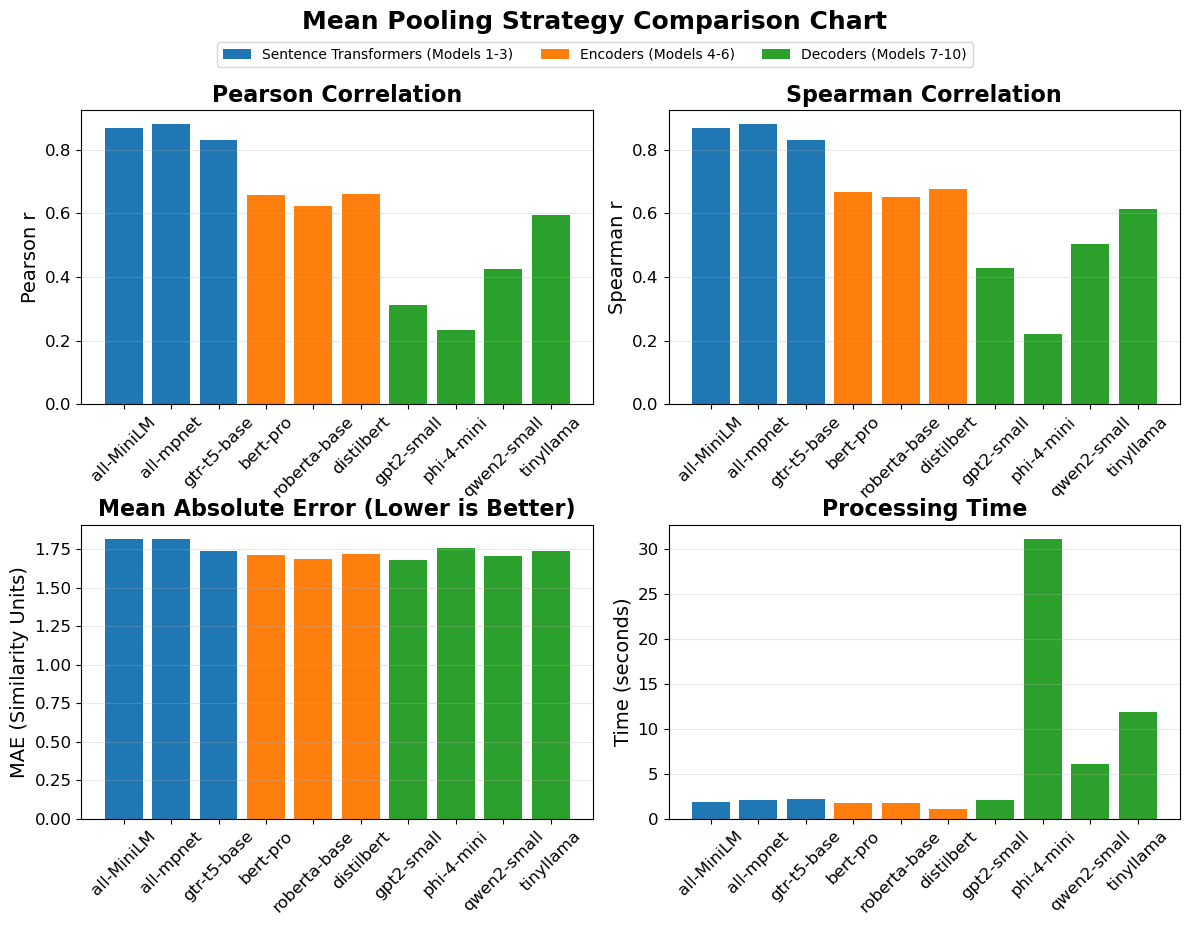

Chart saved as 'model_comparison_chart.png'


<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv('model_evaluation_results.csv')

# Define model types and colors
model_types = {
    'Sentence Transformers': {'start': 0, 'end': 3, 'color': '#1f77b4'}, # Blue
    'Encoder Only': {'start': 3, 'end': 6, 'color': '#ff7f0e'}, # Orange
    'Decoders': {'start': 6, 'end': 10, 'color': '#2ca02c'} # Green
}

# Color array based on model types
colors = []
for i in range(len(df)):
    if i < 3:
        colors.append('#1f77b4') # Blue for sentence transformers
    elif i < 6:
        colors.append('#ff7f0e') # Orange for encoders
    else:
        colors.append('#2ca02c') # Green for decoders

# Figure setup
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Add main title
fig.suptitle('Mean Pooling Strategy Comparison Chart', fontsize=18, fontweight='bold', y=0.92)

# Plot 1: Pearson Correlation
axes[0, 0].bar(df['model'], df['pearson_r'], color=colors)
axes[0, 0].set_title('Pearson Correlation', fontweight='bold', fontsize=16)
axes[0, 0].set_ylabel('Pearson r', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 0].tick_params(axis='y', labelsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Spearman Correlation
axes[0, 1].bar(df['model'], df['spearman_r'], color=colors)
axes[0, 1].set_title('Spearman Correlation', fontweight='bold', fontsize=16)
axes[0, 1].set_ylabel('Spearman r', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 1].tick_params(axis='y', labelsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Mean Absolute Error
axes[1, 0].bar(df['model'], df['mae'], color=colors)
axes[1, 0].set_title('Mean Absolute Error (Lower is Better)', fontweight='bold', fontsize=16)
axes[1, 0].set_ylabel('MAE (Similarity Units)', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 0].tick_params(axis='y', labelsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Processing Time
axes[1, 1].bar(df['model'], df['time'], color=colors)
axes[1, 1].set_title('Processing Time', fontweight='bold', fontsize=16)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 1].tick_params(axis='y', labelsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Sentence Transformers (Models 1-3)'),
    Patch(facecolor='#ff7f0e', label='Encoders (Models 4-6)'),
    Patch(facecolor='#2ca02c', label='Decoders (Models 7-10)')
]

# Add legend to figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.895), ncol=3, fontsize=10)

# Adjust layout for no overlap
plt.tight_layout()
plt.subplots_adjust(top=0.82) # Leave more room for title and legend

# Display plot
plt.show()

# Save plot with higher DPI for crisp text in papers
plt.savefig('model_comparison_chart.png', dpi=600, bbox_inches='tight', facecolor='white')
print("Chart saved as 'model_comparison_chart.png'")